In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
bool_cmap = colors.ListedColormap([(1, 1, 1, 0), 'black'])
from fastadjust.io import h5read
from flyion import initialize, fly
from flyion.trajectory import final_position, trajectory

In [2]:
# constants
from scipy.constants import centi, milli, e, m_e
dt = 5e-11

## Fast Adjust Potential Arrays

In [3]:
# SIMION array
fil = os.path.join(r"./", "mcp.h5")
fa = h5read(fil)
# move xy origin to center of the grid
fa.x0 = - (fa.nx - 1) * fa.dx / 2 
fa.y0 = - (fa.ny - 1) * fa.dy / 2 - 0.01275
fa.z0 = -0.025

## Single electron trajectory

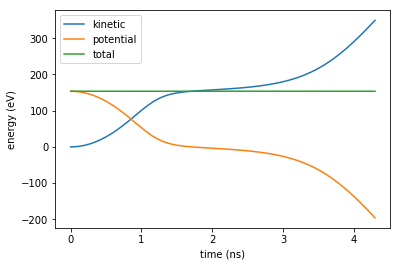

In [4]:
tr = trajectory(fa,
                lambda t: [0, +200, -300],
                t0=0.0,
                x0=[0.0, 0.0, 0.0],
                v0=[0.0, 0.0, 0.0],
                charge=-e,
                mass=m_e,
                dt=dt)

# plot
fig, ax = plt.subplots()

ax.plot(1e9 * tr.index, tr.KE / e, label="kinetic")
ax.plot(1e9 * tr.index, tr.PE / e, label="potential")
ax.plot(1e9 * tr.index, (tr.PE + tr.KE) / e, label="total")

# format
ax.legend()
ax.set_ylabel("energy (eV)")
ax.set_xlabel("time (ns)")

# output
plt.show()

## Monte Carlo
### static field

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.94it/s]


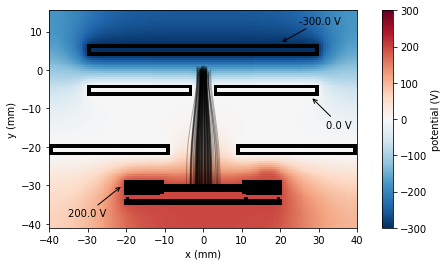

In [5]:
voltages = np.array([0, +200, -300], dtype='float64')
el = fa.electrode
phi = fa.potential(voltages)

# potential
zg = 50
fig, ax = plt.subplots(figsize=(9, 4))
c0 = ax.imshow(phi[:, :, zg].T, origin='lower', extent=fa.extent[:4] / milli, vmax=300, cmap='RdBu_r')
cbar = fig.colorbar(c0, label='potential (V)')
c0 = ax.imshow(el[:, :, zg].T, origin='lower', extent=fa.extent[:4] / milli, cmap=bool_cmap, vmin=0, vmax=1)

# electrons
initial = initialize(100, sigma_x=1e-3)
df = fly(fa, lambda t: voltages, initial, -e, m_e, dt=dt, mode="full")
for i in np.unique(df.index.get_level_values(0)):
    tr = df.loc[i]
    ax.plot(tr.x*1e3, tr.y*1e3, c='k', lw=1, alpha=0.3)

# annotate
ax.annotate(f"{voltages[0]} V", xy=(28, -7),
            arrowprops=dict(arrowstyle='->'), xytext=(32, -15))
ax.annotate(f"{voltages[1]} V", xy=(-21, -30),
            arrowprops=dict(arrowstyle='->'), xytext=(-35, -38))
ax.annotate(f"{voltages[2]} V", xy=(20, 7),
            arrowprops=dict(arrowstyle='->'), xytext=(25, 12))
    
# format
ax.set_aspect('equal')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

# output
out_fil = "electrons.png"
plt.savefig(out_fil, bbox_inches="tight", dpi=200)
plt.show()

#### time of flight

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.28it/s]


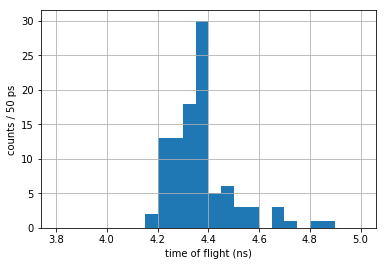

In [6]:
ff = fly(fa, lambda t: [0, +200, -300], initial, -e, m_e, dt=dt, mode="final")

# plot
fig, ax = plt.subplots()

bins = np.arange(3.8, 5, 0.05)
(ff.time * 1e9).hist(ax=ax, bins=bins)

# format
ax.set_xlabel('time of flight (ns)')
ax.set_ylabel('counts / 50 ps')

# output
plt.show()

### ramped field

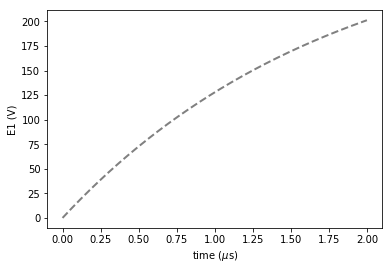

In [7]:
def voltage_ramp(t, t0, tau, voltage):
    def ramp(t):
        return voltage * ((1 - np.exp(- (t - t0) / tau)))
    return np.piecewise(t, [t - t0 < 0], [0.0, ramp])

# plot
fig, ax = plt.subplots()

tvals = np.linspace(0, 2.0, 500) * 1e-6
p0 = [0., 1.8e-6, 300]
ax.plot(tvals * 1e6, voltage_ramp(tvals, *p0), ls="--", lw=2, c="grey")

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('E1 (V)')

# output
plt.show()

#### time of flight

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


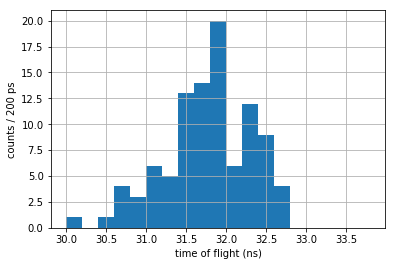

In [8]:
ff = fly(fa, lambda t: [0, 200, -voltage_ramp(t, *p0)], initial, -e, m_e, dt=dt, mode="final")

# plot
fig, ax = plt.subplots()

bins = np.arange(30.0, 34.0, 0.2)
(ff.time * 1e9).hist(ax=ax, bins=bins)

# format
ax.set_xlabel('time of flight (ns)')
ax.set_ylabel('counts / 200 ps')

# output
plt.show()

## ionization time

In [9]:
num = 300
ionize = initialize(num)
# linear sample of ionization times
ionize.time = np.linspace(0, 2, num) * 1e-6
# detection time
detection_time = fly(fa, lambda t: [0, 200, -voltage_ramp(t, *p0)], ionize, -e, m_e, dt=dt, mode="final").time

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.93it/s]


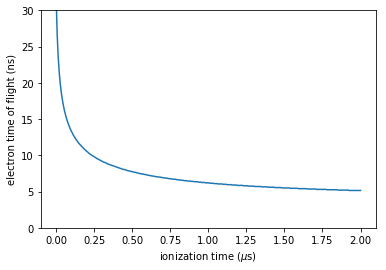

In [10]:
# plot
fig, ax = plt.subplots()

ax.plot(ionize.time * 1e6, (detection_time - ionize.time) * 1e9)

# format
ax.set_ylim(0, 30)
ax.set_xlabel('ionization time ($\mu$s)')
ax.set_ylabel('electron time of flight (ns)')

# output
plt.show()